In [1]:
pip install noise

Note: you may need to restart the kernel to use updated packages.


In [348]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import noise
import re


def csv_to_dataframe(file_name):
    return pd.read_csv(file_name)

In [349]:
from math import sqrt

def distanceSquared3D(point, other):
    return (point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2

def sphereIsInSphere(spheres, point, radio):
    for sphere in spheres:
        if distanceSquared3D(point, sphere[0]) < sphere[1]**2:
            return True
    return False

# take second element for sort
def takeSecond(elem):
    return elem[1]

def makeSpheres(dataframe, max_spheres): #dataframe = (x,y,z,density,distance)
    coordinates_spheres = [] #[(Point,r)]
    
    for i in range(len(dataframe)):
        distance = dataframe.iloc[i].distance
        if (len(coordinates_spheres) < max_spheres):
            coord = [dataframe.iloc[i].x, dataframe.iloc[i].y, dataframe.iloc[i].z]
            isInSphere = sphereIsInSphere(coordinates_spheres, coord, distance)
            if(not isInSphere):
                coordinates_spheres.append([coord, distance])
    
    return coordinates_spheres

def generateSpheres(dataframe, max_spheres):
    sort_dataframe = dataframe.sort_values(by="distance", ascending=False)
    spheresPoints = makeSpheres(sort_dataframe, max_spheres)
    return spheresPoints

In [350]:
import matplotlib.pyplot as plt

def plot_3D_distances(dataframe, x, y, z, distance) -> None:
    vmin = min(dataframe['distance'])
    vmax = max(dataframe['distance'])
    print("plot_3D")
   
    # Creating figure fig = plt.figure(figsize=(20, 13))
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection="3d")

    # Add x, y gridlines
    ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.3, alpha=0.2)

    # Creating plot
    sctt = ax.scatter3D(x, y, z, alpha=0.8, c=distance/2.0, norm = plt.Normalize(vmin=vmin, vmax=vmax), 
                        cmap='terrain', marker='o')

    plt.title("Terrain plot")
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    ax.set_zlim(0, 100)
    ax.set_xlabel('X-axis', fontweight='bold')
    ax.set_ylabel('Y-axis', fontweight='bold')
    ax.set_zlabel('Z-axis', fontweight='bold')
    fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)

    # show plot
    plt.show()

In [442]:
def makeOffset(x,y,z):
    return {'x': x, 'y':y, 'z': z}

class OctreeNode:
    def __init__(self, bounding_box, center, depth):
        self.children = []
        self.bounding_box = bounding_box
        self.center= center         
        self.depth = depth
        self.sphere_data = None

class BigTerrain:
    def __init__(self, dim_x,dim_y,dim_z, block_width, points_per_dimention, max_spheres):
        # Each terrain is compound of a matrix full of terrains
        self.terrain_octants_matrix = []
        self.sdfs_per_octant_matrix = []
        self.spheres_per_octant_matrix = []
        self.block_width = block_width
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.points_per_dimention = points_per_dimention
        self.max_spheres_per_block = max_spheres
        self.internalValues = [[0.0,0.25], [0.25,0.51], [0.51,0.85], [0.85,1.0]]
        self.bvh = None
        self.bvh_depth = -1
        self.bvh_cube_position_map = {}
        
        
    def setPointsPerDimention(self, points):
        self.points_per_dimention = points
        
    def getBlock(self, x,y,z):
        return self.terrain_octants_matrix[x][y][z]
    
    def getBlockHue(self, x,y,z):
        hue = [1.0, 1.0, 1.0]        
        return hue
    
    def hashCube(self, center):
        return "{},{},{}".format(round(center[0],5), round(center[1],5), round(center[2],5))
    
    def generateFlatDensity(self, i, j, k):
        density = 0
        height = j/float(self.block_width)
        if (height >= self.internalValues[0][0] and height < self.internalValues[0][1]):
            density = self.internalValues[0][0]
        if (height >= self.internalValues[1][0] and height < self.internalValues[1][1]):
            density = self.internalValues[1][0]
        if (height >= self.internalValues[2][0] and height < self.internalValues[2][1]):
            density = self.internalValues[2][0]
        if (height >= self.internalValues[3][0] and height < self.internalValues[3][1]):
            density = self.internalValues[3][0]
        return density
    
    def generateSphericalDensity(self, i, j, k):
        sphere_center = [self.block_width/2.0, self.block_width/2.0, self.block_width/2.0]
        point = [i, j, k]
        r = 50
        distance_squared = (point[0] - sphere_center[0])**2 + (point[1] - sphere_center[1])**2 + (point[2] - sphere_center[2])**2
        if distance_squared <= r**2:
            # solid sphere density
            return self.internalValues[3][0]
        else:
            # water density
            return self.internalValues[0][0]
        
    def generatePerlinDensity(self, i,j,k):
        scale = float(self.block_width)
        return noise.pnoise3(i / scale, j / scale,
                                        k / scale,
                                        octaves=6,
                                        persistence=0.5,
                                        lacunarity=2.0,
                                        repeatx=1024,
                                        repeaty=1024,
                                        repeatz=1024,
                                        base=42)
    
    def generateDensity(self, i, j, k, block_idx):
        #return self.generatePerlinDensity(i,j,k)
        if block_idx % 8 == 0:
            return self.generateFlatDensity(i, j, k)
        if block_idx % 8 == 1:
            return self.generateSphericalDensity(i, j, k)
        if block_idx % 8 == 2:
            return self.internalValues[3][0]
        if block_idx % 8 == 3:
            return self.internalValues[2][0]
        if block_idx % 8 == 4:
            return self.internalValues[3][0]
        if block_idx % 8 == 5:
            return self.internalValues[0][0]
        if block_idx % 8 == 6:
            return -1
        if block_idx % 8 == 7:
            return self.internalValues[1][0]
    
    # TODO: Allow not complete octrees. O sea, que no todos los niveles tengan que estar completos. Lo cual es equivalente
    # a tener octantes con mas niveles de subdivisiones que otros.
    def generateFromDensityCube(self, density_cube, subdivision_level): 
        self.bvh_depth = subdivision_level
        # Subdivision level starts at 0 for root node.
        # Each level of the tree splits the axix in 2, that's why we have 2 as base. The 8 children are computed by the product
        # of 2 divisions in 3 dimensions. 2 * 2 * 2 = 8 Nice :)
        divisions_per_dimention = 2**(subdivision_level)
        self.block_width = density_cube.block_width / float(divisions_per_dimention)

        self.dim_x = divisions_per_dimention
        self.dim_y = divisions_per_dimention
        self.dim_z = divisions_per_dimention
        
        self.points_per_dimention = int(density_cube.points_per_dimention / divisions_per_dimention)
        if (density_cube.points_per_dimention % divisions_per_dimention != 0):
            print ("Warning: Subdivision level is not a multiple of points per dimention in original cube.")
            
        # First block. TODO: Refactor to not generate a big terrain before.
        density_cube_data = density_cube.terrain_octants_matrix[0][0][0]
        
        for i in range(self.dim_x):
            self.terrain_octants_matrix.append([])
            for j in range(self.dim_y):
                self.terrain_octants_matrix[i].append([])
                for k in range(self.dim_z):
                    cube_center = [self.block_width/2.0 + i * self.block_width, self.block_width/2.0 + j * self.block_width, self.block_width/2.0 + k * self.block_width]
                    self.bvh_cube_position_map[self.hashCube(cube_center)] = [i,j,k]
                    terrain = []
                    for x in range(self.points_per_dimention):
                        for y in range(self.points_per_dimention):
                            for z in range(self.points_per_dimention):
                                index = (z + k * self.points_per_dimention) + (y + j * self.points_per_dimention) * density_cube.points_per_dimention + (x + i * self.points_per_dimention) * density_cube.points_per_dimention**2
                                point = density_cube_data.loc[index]
                                terrain.append([point['x'], point['y'], point['z'], point['density']])
                    
                    self.terrain_octants_matrix[i][j].append(pd.DataFrame(np.array(terrain), 
                                                                          columns=['x', 'y', 'z', 'density']))
        
        
    def buildBVH(self):
        # Build root node.
        box_width = 2**self.bvh_depth * self.block_width/2.0
        bbox = [box_width, box_width, box_width]
        center = [box_width, box_width, box_width]
        root = OctreeNode(bbox, center, 0)
        
        # Build tree
        stack = []
        stack.append(root)
        while len(stack) > 0:
            # Fifo order.
            currentNode = stack.pop(0)
            if (currentNode.depth == self.bvh_depth):
                s_idx = self.bvh_cube_position_map[self.hashCube(currentNode.center)]
                currentNode.sphere_data = self.spheres_per_octant_matrix[s_idx[0]][s_idx[1]][s_idx[2]]
                continue
                
            child_depth = currentNode.depth + 1
            # Generate children
            for i in range(8):
                box_width = 2**(self.bvh_depth - child_depth) * self.block_width/2.0
                bbox = [box_width, box_width, box_width]
                
                if i == 0:
                    center = [currentNode.center[0] - box_width, currentNode.center[1] - box_width, currentNode.center[2] - box_width]
                if i == 1:
                    center = [currentNode.center[0] - box_width, currentNode.center[1] - box_width, currentNode.center[2] + box_width]
                if i == 2:
                    center = [currentNode.center[0] - box_width, currentNode.center[1] + box_width, currentNode.center[2] - box_width]
                if i == 3:
                    center = [currentNode.center[0] - box_width, currentNode.center[1] + box_width, currentNode.center[2] + box_width]
                if i == 4:
                    center = [currentNode.center[0] + box_width, currentNode.center[1] - box_width, currentNode.center[2] - box_width]
                if i == 5:
                    center = [currentNode.center[0] + box_width, currentNode.center[1] - box_width, currentNode.center[2] + box_width]
                if i == 6:
                    center = [currentNode.center[0] + box_width, currentNode.center[1] + box_width, currentNode.center[2] - box_width]
                if i == 7:
                    center = [currentNode.center[0] + box_width, currentNode.center[1] + box_width, currentNode.center[2] + box_width]
            
                childNode = OctreeNode(bbox, center, child_depth)
                currentNode.children.append(childNode)
                stack.append(childNode)
                
        # Store bvh
        self.bvh = root
    
    def generateBlock(self, offset, block_idx):
        terrain = []        
        size = float(self.block_width)
        step = size/self.points_per_dimention
        cube_discretization = np.arange(0, self.block_width, step)
        for i in cube_discretization:
            for j in cube_discretization:
                for k in cube_discretization:
                    terrain.append([i+offset['x'], j+offset['y'], k+offset['z'],
                                    self.generateDensity(i, j, k, block_idx)])
                    
        dataframe = pd.DataFrame(np.array(terrain), columns=['x', 'y', 'z', 'density'])
        return dataframe
    
    def generateBigTerrain(self):
        block_idx = 0
        for i in range(self.dim_x):
            self.terrain_octants_matrix.append([])
            for j in range(self.dim_y):
                self.terrain_octants_matrix[i].append([])
                for k in range(self.dim_z):
                    block = self.generateBlock(makeOffset(i * self.block_width, j  * self.block_width, k * self.block_width), block_idx)
                    self.terrain_octants_matrix[i][j].append(block)
                    block_idx = block_idx + 1
    
    def getColorFromDensity(self, density):
        if density < 0:
            return [0.0, 0.0, 0.0]
        if (density >= self.internalValues[0][0] and density < self.internalValues[0][1]):
            return [0, 1.0, 239/255.0]
        if (density >= self.internalValues[1][0] and density < self.internalValues[1][1]):
            return [199/255.0, 234/255.0, 70/255.0]
        if (density >= self.internalValues[2][0] and density < self.internalValues[2][1]):
            return [251/255.0, 251/255.0, 148/255.0]
        if (density >= self.internalValues[3][0] and density <= self.internalValues[3][1]):
            return [159/255.0, 129/255.0, 112/255.0]

    def getNeighbors(self, density_object_cube, position):
        e = density_object_cube.index[position]
        plane_size = self.block_width * self.block_width
               
        # Plane 1 (x == 0)
        # [x, y, z], [x,y, z+1], [x, y, z+2]
        # [x, y+1, z], [x,y+1, z+1], [x, y+1, z+2]
        # [x, y+2, z], [x,y+2, z+1], [x, y+2, z+2]
        
        # Plane 2 (x == 1)
        # [x+1, y, z], [x+1,y, z+1], [x+1, y, z+2]
        # [x+1, y+1, z], [x+1,y+1, z+1], [x+1, y+1, z+2]
        # [x+1, y+2, z], [x+1,y+2, z+1], [x+1, y+2, z+2]
        
        # Plane 3 (x == 2)
        # [x+2, y, z], [x+2,y, z+1], [x+2, y, z+2]
        # [x+2, y+1, z], [x+2,y+1, z+1], [x+2, y+1, z+2]
        # [x+2, y+2, z], [x+2,y+2, z+1], [x+2, y+2, z+2]
        
        all_posible_neighbors = [   
                        # Plane
                      e - 1, e + 1, # Left/Right
                      e - 1 - self.block_width, e - self.block_width, e + 1 - self.block_width, # Bottom
                      e - 1 + self.block_width, e + self.block_width, e + 1 + self.block_width, # Up 
                        # Plane - 1
                      e - plane_size, # Center 
                      e - 1 - plane_size, e + 1 - plane_size, # Left/Right
                      e - 1 - self.block_width - plane_size, e - self.block_width - plane_size, e + 1 - self.block_width - plane_size, # Bottom
                      e - 1 + self.block_width - plane_size, e + self.block_width - plane_size, e + 1 + self.block_width - plane_size, # Up 
                        # Plane + 1
                      e + plane_size, # Center 
                      e - 1 + plane_size, e + 1 + plane_size, # Left/Right
                      e - 1 - self.block_width + plane_size, e - self.block_width + plane_size, e + 1 - self.block_width + plane_size, # Bottom
                      e - 1 + self.block_width + plane_size, e + self.block_width + plane_size, e + 1 + self.block_width + plane_size # Up 
                    ]
        
        neighbors = []
        for n in all_posible_neighbors:
            if n in density_object_cube.index:
                neighbors.append([n, density_object_cube.index.get_loc(n)])
        
        # [[index, position_in_dataframe], ...]
        return neighbors
    
    def lookForFrontiers(self, density_object_cube):
        INFINITE_DISTANCE = 9999999999999
        TO_PROCESS_DISTANCE = -1
        distances = [INFINITE_DISTANCE] * len(density_object_cube)
        
        neighbors_per_node_cache = [[]] * len(density_object_cube)
        next_frontier_nodes_set = set()
        frontier_level = 1
        for i in range(len(density_object_cube)):
            if neighbors_per_node_cache[i] == []:
                neighbors = self.getNeighbors(density_object_cube, i)
                neighbors_per_node_cache[i] = neighbors
            else:
                neighbors = neighbors_per_node_cache[i]
                
            if len(neighbors) != 26:
                # If I don't have 26 neighbors then at least 1 is missing, that means I'm border.
                # Check later how to differentiate diagonal and direct neighbors for the correction factor.
                distances[i] = frontier_level
                for n in neighbors:
                    # Calculate neighbors of neighbor.
                    if neighbors_per_node_cache[n[1]] == []:
                        neighbors_of_neighbor = self.getNeighbors(density_object_cube, n[1])
                        neighbors_per_node_cache[n[1]] = neighbors_of_neighbor
                    else:
                        neighbors_of_neighbor = neighbors_per_node_cache[n[1]]
                        
                    # Filter borders.
                    if len(neighbors_of_neighbor) != 26:
                        distances[n[1]] = frontier_level
                        
                    # If it's a neighbor of a border, only add the ones who haven't been calculated yet.
                    if distances[n[1]] == INFINITE_DISTANCE:
                        distances[n[1]] = TO_PROCESS_DISTANCE
                        next_frontier_nodes_set.add(n[1])
                
        # All neighbors are computed and frontier delimited.
        # Now iterate for all of distance 2, all of distance 3 and so forth. N**3 * N/2
        # Distance column is the way to tell if the node has been computed or not.
        
        while True:
            frontier_level = frontier_level + 1
            current_frontier_nodes_set = next_frontier_nodes_set
            next_frontier_nodes_set = set()
            while current_frontier_nodes_set:
                i = current_frontier_nodes_set.pop()
                if neighbors_per_node_cache[i] == []:
                    neighbors = self.getNeighbors(density_object_cube, i)
                    neighbors_per_node_cache[i] = neighbors
                else:
                    neighbors = neighbors_per_node_cache[i]
            
                distances[i] = frontier_level
                for n in neighbors:
                    # Only add to next frontiers nodes which has infinite distance. 
                    # This way we discard frontiers and TO_PROCESS nodes.
                    if distances[n[1]] == INFINITE_DISTANCE:
                        distances[n[1]] = TO_PROCESS_DISTANCE
                        next_frontier_nodes_set.add(n[1])
            if not next_frontier_nodes_set:
                break
            
        # Just verify that all distances are processed.
        errors = 0
        for d in distances:
            if d == INFINITE_DISTANCE or d == TO_PROCESS_DISTANCE:
                errors = errors + 1
        
        print ("Errors: {}".format(errors))
        
        step = float(self.block_width)/self.points_per_dimention
        return list(map(lambda x: x * step, distances))    
        
    def calculateSdfForBlock(self, block):
        # For now lets assume that sdfs are conex blocks and we only have 4 internal values.
        sdf_water = block[(block.density >= self.internalValues[0][0]) & (block.density < self.internalValues[0][1])]
        sdf_grass = block[(block.density >= self.internalValues[1][0]) & (block.density < self.internalValues[1][1])]
        sdf_meadow = block[(block.density >= self.internalValues[2][0]) & (block.density < self.internalValues[2][1])]
        sdf_rock = block[(block.density >= self.internalValues[3][0]) & (block.density <= self.internalValues[3][1])]
        
        # Calculate distances.
        
        sdf_water['distance'] = self.lookForFrontiers(sdf_water)
        sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)
        sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)
        sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)
        
        return [sdf_water, sdf_grass, sdf_meadow, sdf_rock]
    
    def calculateSdf(self):
        for i in range(self.dim_x):
            self.sdfs_per_octant_matrix.append([])
            for j in range(self.dim_y):
                self.sdfs_per_octant_matrix[i].append([])
                for k in range(self.dim_z):
                    self.sdfs_per_octant_matrix[i][j].append(self.calculateSdfForBlock(self.terrain_octants_matrix[i][j][k]))
    
    def computeEditsForBlock(self, sdfs):        
        return [[generateSpheres(sdfs[0], self.max_spheres_per_block), [0, 1.0, 239/255.0]], 
                [generateSpheres(sdfs[1], self.max_spheres_per_block), [199/255.0, 234/255.0, 70/255.0]], 
                [generateSpheres(sdfs[2], self.max_spheres_per_block), [251/255.0, 251/255.0, 148/255.0]],
                [generateSpheres(sdfs[3], self.max_spheres_per_block), [159/255.0, 129/255.0, 112/255.0]]]
    
    def computeEdits(self):
        for i in range(self.dim_x):
            self.spheres_per_octant_matrix.append([])
            for j in range(self.dim_y):
                self.spheres_per_octant_matrix[i].append([])
                for k in range(self.dim_z):
                    self.spheres_per_octant_matrix[i][j].append(self.computeEditsForBlock(self.sdfs_per_octant_matrix[i][j][k]))
    
    def getTotalSpheres(self):
        total_spheres = 0
        for i in range(self.dim_x):
            for j in range(self.dim_y):
                for k in range(self.dim_z):
                    for w in range(4):
                        total_spheres = total_spheres + len(self.spheres_per_octant_matrix[i][j][k][w][0])
                    
        return total_spheres
    
    def plotEditsForBlock(self, ax, all_spheres):
        # ax = plt.axes(projection="3d")
        for set_of_spheres in all_spheres:
            spheres = set_of_spheres[0]
            color = set_of_spheres[1]
            
            for sphere in spheres:
                # ax = fig.gca(projection='3d')
                r = sphere[1]
                c = sphere[0]
        
                # draw sphere
                u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
                x = r*np.cos(u)*np.sin(v)
                y = r*np.sin(u)*np.sin(v)
                z = r*np.cos(v)
    
                ax.plot_surface(x-c[0], y-c[2], z-c[1], color=color)
    
    def plotEdits(self):
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(projection='3d')

        for i in range(self.dim_x):
            for j in range(self.dim_y):
                for k in range(self.dim_z):
                    spheres = self.spheres_per_octant_matrix[i][j][k]
                    self.plotEditsForBlock(ax, spheres)
                    
        # show plot
        plt.show()
            
    def plotBlock(self, fig, ax, dataframe, block_color_hue) -> None:
        vmin = min(dataframe['density'])
        vmax = max(dataframe['density'])

        color = list(map(self.getColorFromDensity,dataframe['density']))
        color = list(map(lambda x: [block_color_hue[0] * x[0],block_color_hue[1] * x[1],block_color_hue[2] * x[2]], color))
        
        # Creating plot
        sctt = ax.scatter3D(dataframe['x'], dataframe['z'], dataframe['y'], alpha=0.8, c=color, norm = plt.Normalize(vmin=vmin, vmax=vmax), 
                            marker='o')

        plt.title("Terrain plot")
        plt.xlim(0, self.dim_x * self.block_width)
        plt.ylim(0, self.dim_z * self.block_width)
        ax.set_zlim(0, self.dim_y * self.block_width)
        ax.set_xlabel('X-axis', fontweight='bold')
        ax.set_ylabel('Z-axis', fontweight='bold')
        ax.set_zlabel('Y-axis', fontweight='bold')
    
    def plot(self):
        # Creating figure fig = plt.figure(figsize=(20, 13))
        fig = plt.figure(figsize=(15, 15))
        ax = plt.axes(projection="3d")

        # Add x, y gridlines
        ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.3, alpha=0.2)
        for i in range(self.dim_x):
            for j in range(self.dim_y):
                for k in range(self.dim_z):
                    dataframe = self.terrain_octants_matrix[i][j][k]
                    block_color_hue = self.getBlockHue(i,j,k)
                    self.plotBlock(fig, ax, dataframe, block_color_hue)
                    
        # show plot
        plt.show()
    
    def replaceParameters(self, line, config):
        match = re.search("\$\{.*\}", line)
        if match is None:
            return line
        else:
            return match.string.replace(match.group(), config[match.group()])
    def nodeToString(self, node):
        return "{{\n\t\t\tbbox:new THREE.Vector3({},{},{}),\n\t\t\tcenter: new THREE.Vector3({},{},{}),\n\t\t\tdepth: {}\n\t\t}}".format(node.bounding_box[0], node.bounding_box[1], node.bounding_box[2], node.center[0], node.center[1], node.center[2], node.depth)

    def leafDataToString(self, start_sdf1,start_sdf2, 
                                          start_sdf3, 
                                          start_sdf4, end_sdf):
        return "{{\n\t\t\tstart_sdf1: {},\n\t\t\tstart_sdf2: {},\n\t\t\tstart_sdf3: {},\n\t\t\tstart_sdf4: {},\n\t\t\tend_sdf: {}\n\t\t}}".format(start_sdf1, 
                                          start_sdf2, 
                                          start_sdf3,
                                          start_sdf4, end_sdf)

    def generateShaderWithTextures(self):
        CONFIG_PARAMETERS_SHADER = {
            '${MAX_SPHERES_PER_OCTANT}': str(self.max_spheres_per_block),
            '${MAX_TREE_DEPTH}': str(self.bvh_depth), 
            '${AMOUNT_OF_NODES_IN_TREE}': str(int((8**(self.bvh_depth+1) - 1)/7)), 
            '${AMOUNT_OF_LEAVES_IN_TREE}': str(8**self.bvh_depth),
            '${TOTAL_SPHERES}': str(self.getTotalSpheres()),
            '${SDF1_COLOR}': '0.0, 1.0, 239.0/255.0',
            '${SDF2_COLOR}': '199.0/255.0, 234.0/255.0, 70.0/255.0',
            '${SDF3_COLOR}': '251.0/255.0, 251.0/255.0, 148.0/255.0',
            '${SDF4_COLOR}': '159.0/255.0, 129.0/255.0, 112.0/255.0',
            '${SMOOTH_UNION_K}': '10.0'
        }

        with open('./templates/shaders/fragmentShaders/raymarcher.glsl') as f:
            lines = f.readlines()
            lines_to_write = map(lambda x: self.replaceParameters(x, CONFIG_PARAMETERS_SHADER), lines)
            with open('./generatedCode/raymarcher.glsl', 'w') as fw:
                fw.writelines(lines_to_write)

        nodes = []
        leaf_data = []
        spheres = []
        
        stack = []
        stack.append(self.bvh)
        spheres_pointer = 0
        while len(stack) > 0:
            currentNode = stack.pop(0)
            # Add nodes.
            nodes.append(self.nodeToString(currentNode))
    
            # Fifo order. Leaf nodes are traversed in order.
            if (currentNode.depth == self.bvh_depth):
                # Add spheres.
                start_sdf1 = spheres_pointer
                c = start_sdf1
                for s in currentNode.sphere_data[0][0]:
                    spheres.append("new THREE.Vector4({}, {}, {}, {})".format(s[0][0], s[0][1], s[0][2], s[1]))
                    c = c + 1
                
                start_sdf2 = c 
                for s in currentNode.sphere_data[1][0]:
                    spheres.append("new THREE.Vector4({}, {}, {}, {})".format(s[0][0], s[0][1], s[0][2], s[1]))
                    c = c +1
            
                start_sdf3 = c
                for s in currentNode.sphere_data[2][0]: # Add slice fro msphere_pointer
                    spheres.append("new THREE.Vector4({}, {}, {}, {})".format(s[0][0], s[0][1], s[0][2], s[1]))
                    c = c + 1
            
                start_sdf4 = c
                for s in currentNode.sphere_data[3][0]:
                    spheres.append("new THREE.Vector4({}, {}, {}, {})".format(s[0][0], s[0][1], s[0][2], s[1]))
                    c = c + 1
                
                spheres_pointer = c    
        
                # Generate leaf_data.
                leaf_data.append(self.leafDataToString(start_sdf1, 
                                          start_sdf2,
                                          start_sdf3,
                                          start_sdf4, c))
            else:   
                #Traverse children
                for i in range(8):
                    stack.append(currentNode.children[i])

        # Join strings.
        nodes_string = ','.join(nodes)
        leaf_data_string = ','.join(leaf_data)
        spheres_string = ',\n\t\t\t'.join(spheres)
    
        CONFIG_PARAMETERS_MATERIAL = {
            '${NODES}': nodes_string,
            '${LEAF_DATA}': leaf_data_string, 
            '${SPHERES}': spheres_string
        }

        with open('./templates/materials/RaymarcherMaterial.js') as f:
            lines = f.readlines()
            lines_to_write = map(lambda x: self.replaceParameters(x, CONFIG_PARAMETERS_MATERIAL), lines)
            with open('./generatedCode/RaymarcherMaterial.js', 'w') as fw:
                fw.writelines(lines_to_write)       
    
    def generateShaderWithUniformArrays(self):
        CONFIG_PARAMETERS_SHADER = {
            '${MAX_SPHERES_PER_OCTANT}': str(self.max_spheres_per_block),
            '${MAX_TREE_DEPTH}': str(self.bvh_depth), 
            '${AMOUNT_OF_NODES_IN_TREE}': str(int((8**(self.bvh_depth+1) - 1)/7)), 
            '${AMOUNT_OF_LEAVES_IN_TREE}': str(8**self.bvh_depth),
            '${TOTAL_SPHERES}': str(self.getTotalSpheres()),
            '${SDF1_COLOR}': '0.0, 1.0, 239.0/255.0',
            '${SDF2_COLOR}': '199.0/255.0, 234.0/255.0, 70.0/255.0',
            '${SDF3_COLOR}': '251.0/255.0, 251.0/255.0, 148.0/255.0',
            '${SDF4_COLOR}': '159.0/255.0, 129.0/255.0, 112.0/255.0',
            '${SMOOTH_UNION_K}': '10.0'
        }

        with open('./templates/shaders/fragmentShaders/raymarcher.glsl') as f:
            lines = f.readlines()
            lines_to_write = map(lambda x: self.replaceParameters(x, CONFIG_PARAMETERS_SHADER), lines)
            with open('./generatedCode/raymarcher.glsl', 'w') as fw:
                fw.writelines(lines_to_write)

        nodes = []
        leaf_data = []
        spheres = []
        
        stack = []
        stack.append(self.bvh)
        spheres_pointer = 0
        while len(stack) > 0:
            currentNode = stack.pop(0)
            # Add nodes.
            nodes.append(self.nodeToString(currentNode))
    
            # Fifo order. Leaf nodes are traversed in order.
            if (currentNode.depth == self.bvh_depth):
                # Add spheres.
                start_sdf1 = spheres_pointer
                c = start_sdf1
                for s in currentNode.sphere_data[0][0]:
                    spheres.append("new THREE.Vector4({}, {}, {}, {})".format(s[0][0], s[0][1], s[0][2], s[1]))
                    c = c + 1
                
                start_sdf2 = c 
                for s in currentNode.sphere_data[1][0]:
                    spheres.append("new THREE.Vector4({}, {}, {}, {})".format(s[0][0], s[0][1], s[0][2], s[1]))
                    c = c +1
            
                start_sdf3 = c
                for s in currentNode.sphere_data[2][0]: # Add slice fro msphere_pointer
                    spheres.append("new THREE.Vector4({}, {}, {}, {})".format(s[0][0], s[0][1], s[0][2], s[1]))
                    c = c + 1
            
                start_sdf4 = c
                for s in currentNode.sphere_data[3][0]:
                    spheres.append("new THREE.Vector4({}, {}, {}, {})".format(s[0][0], s[0][1], s[0][2], s[1]))
                    c = c + 1
                
                spheres_pointer = c    
        
                # Generate leaf_data.
                leaf_data.append(self.leafDataToString(start_sdf1, 
                                          start_sdf2,
                                          start_sdf3,
                                          start_sdf4, c))
            else:   
                #Traverse children
                for i in range(8):
                    stack.append(currentNode.children[i])

        # Join strings.
        nodes_string = ','.join(nodes)
        leaf_data_string = ','.join(leaf_data)
        spheres_string = ',\n\t\t\t'.join(spheres)
    
        CONFIG_PARAMETERS_MATERIAL = {
            '${NODES}': nodes_string,
            '${LEAF_DATA}': leaf_data_string, 
            '${SPHERES}': spheres_string
        }

        with open('./templates/materials/RaymarcherMaterial.js') as f:
            lines = f.readlines()
            lines_to_write = map(lambda x: self.replaceParameters(x, CONFIG_PARAMETERS_MATERIAL), lines)
            with open('./generatedCode/RaymarcherMaterial.js', 'w') as fw:
                fw.writelines(lines_to_write)       
            
    def evaluateEditsErrorPerBlock(self, block, i, j, k):
        s = 0
        total_points = 0
        misclassified_points = 0
        for sdf in block:
            spheres = self.spheres_per_octant_matrix[i][j][k][s][0]
            for index, point in sdf.iterrows():
                total_points = total_points + 1
                is_inside_sphere = False
                for sphere in spheres:
                    if distanceSquared3D(point, sphere[0]) < sphere[1]**2:
                        is_inside_sphere = True
                        break
                if not is_inside_sphere:
                    misclassified_points = misclassified_points + 1
            s = s + 1    
        print ("For Block [{}][{}][{}], {}/{} points where successfully classified. Error: {}%.".format(i,j,k, total_points - misclassified_points, total_points, misclassified_points/float(total_points)*100))
        return [total_points, misclassified_points]
    
    def evaluateEditsError(self):
        errors = []
        for i in range(self.dim_x):
            for j in range(self.dim_y):
                for k in range(self.dim_z):
                    block = self.sdfs_per_octant_matrix[i][j][k]
                    errors.append(self.evaluateEditsErrorPerBlock(block, i, j, k))
        return errors
        # for each point in octant check whether color is the same asigned. How many points classifies ok. 
        # For that check that each point in spheres per octant list has the same color assigned.
        

In [443]:
volcano = csv_to_dataframe("./volcano_64_64_64.csv")

In [444]:
subdivided_terrain = BigTerrain(1,1,1,64, 64, 20)

In [445]:
subdivided_terrain.terrain_octants_matrix.append([])
subdivided_terrain.terrain_octants_matrix[0].append([])
subdivided_terrain.terrain_octants_matrix[0][0].append(volcano)

In [446]:
subdivided_terrain.terrain_octants_matrix[0][0][0]

,x,y,z,density
0,0.00,0.00,0.00,1.0
1,0.00,0.00,0.05,1.0
2,0.00,0.00,0.10,1.0
3,0.00,0.00,0.15,1.0
4,0.00,0.00,0.20,1.0
...,...,...,...,...
262139,3.15,3.15,2.95,0.0
262140,3.15,3.15,3.00,0.0
262141,3.15,3.15,3.05,0.0
262142,3.15,3.15,3.10,0.0


In [447]:
#subdivided_terrain.calculateSdf()

In [448]:
#subdivided_terrain.computeEdits()

In [449]:
#subdivided_terrain.bvh_depth = 1

In [450]:
#i = 0
#j = 0
#k = 0
#cube_center = [subdivided_terrain.block_width/2.0 + i * subdivided_terrain.block_width, subdivided_terrain.block_width/2.0 + j * subdivided_terrain.block_width, subdivided_terrain.block_width/2.0 + k * subdivided_terrain.block_width]


In [451]:
#subdivided_terrain.bvh_cube_position_map[subdivided_terrain.hashCube(cube_center)] = [i,j,k]

In [452]:
final_subdivided_terrain = BigTerrain(1,1,1,64, 64, 20)

In [453]:
final_subdivided_terrain.generateFromDensityCube(subdivided_terrain, 1)

In [454]:
final_subdivided_terrain.calculateSdf()

Errors: 0
Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)


Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)


Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)


Errors: 0
Errors: 0
Errors: 0
Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:352: SettingWithCopyWarning: 
A value is trying to be set o

Errors: 0
Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)


Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)


Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)


Errors: 0
Errors: 0
Errors: 0
Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:352: SettingWithCopyWarning: 
A value is trying to be set o

Errors: 0
Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)


Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)


Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)


Errors: 0
Errors: 0
Errors: 0
Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:352: SettingWithCopyWarning: 
A value is trying to be set o

Errors: 0
Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)


Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)


Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)


Errors: 0
Errors: 0
Errors: 0
Errors: 0


/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)
/var/folders/n6/f11tq19x1hvgwgx_jnvy12z40000gn/T/ipykernel_98756/2793886621.py:352: SettingWithCopyWarning: 
A value is trying to be set o

In [455]:
final_subdivided_terrain.computeEdits()

In [456]:
final_subdivided_terrain.buildBVH()

In [457]:
final_subdivided_terrain.generateShaderWithTextures()

In [460]:
final_subdivided_terrain.spheres_per_octant_matrix

[[[[[[[[0.35, 0.45, 1.2000000000000002], 8.0]], [0, 1.0, 0.9372549019607843]],
    [[[[1.4, 1.5, 0.9], 2.0]],
     [0.7803921568627451, 0.9176470588235294, 0.27450980392156865]],
    [[[[1.3, 1.05, 1.05], 5.0]],
     [0.984313725490196, 0.984313725490196, 0.5803921568627451]],
    [[[[1.2000000000000002, 0.8500000000000001, 0.35], 8.0]],
     [0.6235294117647059, 0.5058823529411764, 0.4392156862745098]]],
   [[[[[0.6000000000000001, 0.6000000000000001, 2.5], 12.0]],
     [0, 1.0, 0.9372549019607843]],
    [[[[1.4, 1.5, 1.7000000000000002], 2.0]],
     [0.7803921568627451, 0.9176470588235294, 0.27450980392156865]],
    [[[[1.2000000000000002, 1.35, 1.75], 3.0]],
     [0.984313725490196, 0.984313725490196, 0.5803921568627451]],
    [[], [0.6235294117647059, 0.5058823529411764, 0.4392156862745098]]]],
  [[[[[[0.35, 2.8000000000000003, 1.2000000000000002], 8.0]],
     [0, 1.0, 0.9372549019607843]],
    [[[[1.4, 1.7000000000000002, 1.05], 2.0]],
     [0.7803921568627451, 0.9176470588235294,

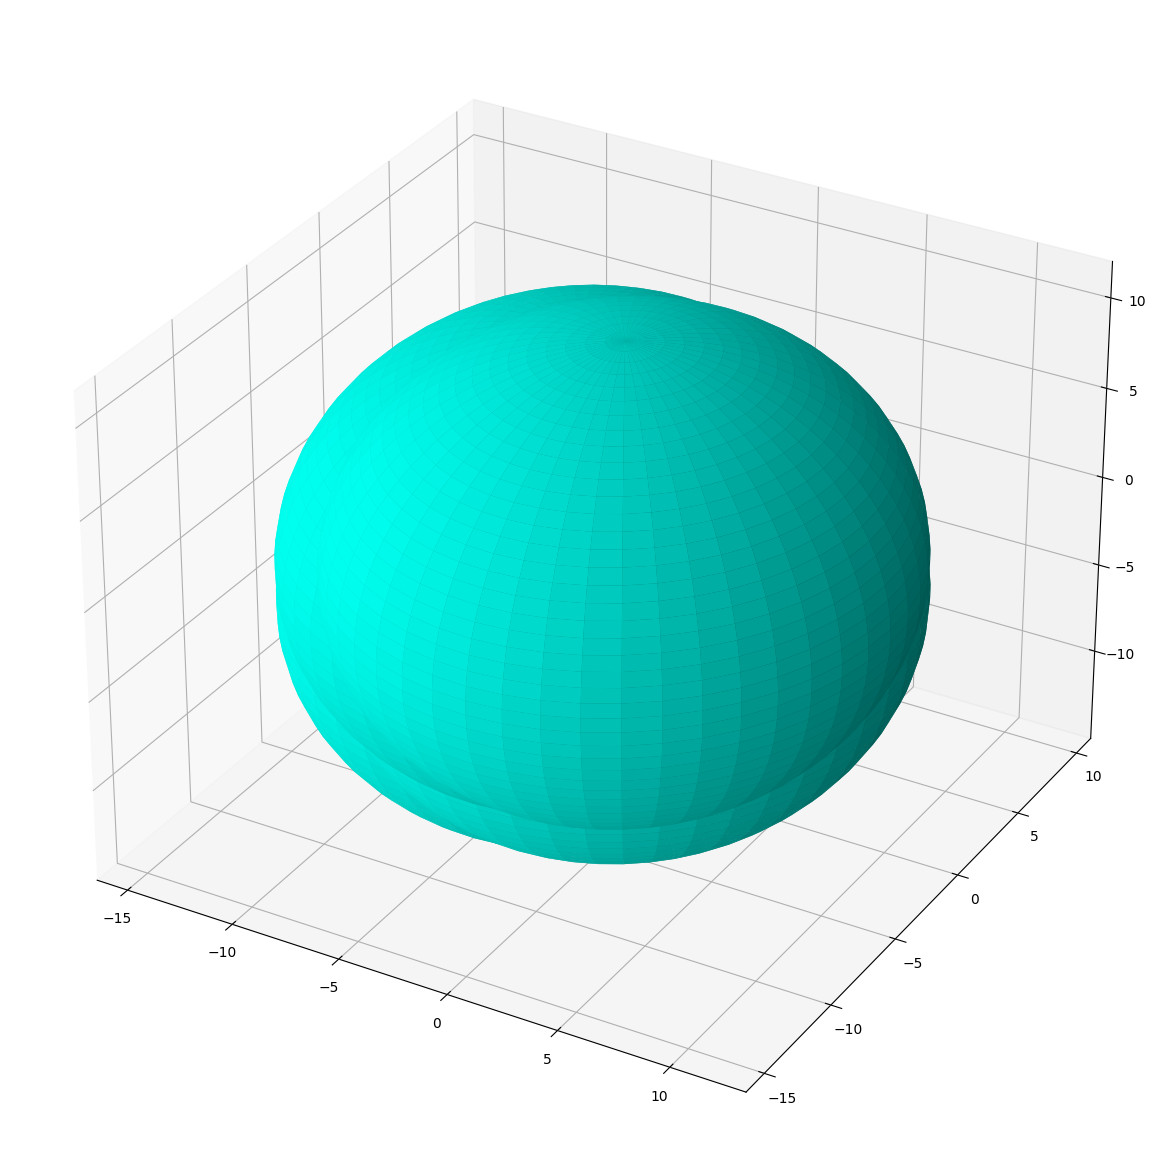

In [459]:
final_subdivided_terrain.plotEdits()

In [20]:
density_cube = BigTerrain(1,1,1,32, 32.0, 20)
density_cube.generateBigTerrain()
subdivided_terrain = BigTerrain(1,1,1,32, 32, 20)
subdivided_terrain.generateFromDensityCube(density_cube, 1)
subdivided_terrain.calculateSdf()
subdivided_terrain.computeEdits()
subdivided_terrain.buildBVH()
subdivided_terrain.generateShader()
subdivided_terrain.evaluateEditsError()
#subdivided_terrain.plot()

Errors: 0


<ipython-input-16-581e9ddb1d14>:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)


Errors: 0


<ipython-input-16-581e9ddb1d14>:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)


Errors: 0
Errors: 0
Errors: 0


<ipython-input-16-581e9ddb1d14>:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)


Errors: 0


<ipython-input-16-581e9ddb1d14>:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)


Errors: 0
Errors: 0
Errors: 0
Errors: 0
Errors: 0


<ipython-input-16-581e9ddb1d14>:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)


Errors: 0
Errors: 0
Errors: 0


<ipython-input-16-581e9ddb1d14>:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)


Errors: 0


<ipython-input-16-581e9ddb1d14>:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)


Errors: 0


<ipython-input-16-581e9ddb1d14>:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)


Errors: 0


<ipython-input-16-581e9ddb1d14>:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)


Errors: 0


<ipython-input-16-581e9ddb1d14>:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)


Errors: 0
Errors: 0
Errors: 0


<ipython-input-16-581e9ddb1d14>:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_water['distance'] = self.lookForFrontiers(sdf_water)


Errors: 0
Errors: 0
Errors: 0
Errors: 0
Errors: 0


<ipython-input-16-581e9ddb1d14>:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_grass['distance'] = self.lookForFrontiers(sdf_grass)


Errors: 0


<ipython-input-16-581e9ddb1d14>:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)


Errors: 0


<ipython-input-16-581e9ddb1d14>:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)


Errors: 0
Errors: 0
Errors: 0


<ipython-input-16-581e9ddb1d14>:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_meadow['distance'] = self.lookForFrontiers(sdf_meadow)


Errors: 0


<ipython-input-16-581e9ddb1d14>:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdf_rock['distance'] = self.lookForFrontiers(sdf_rock)


For Block [0][0][0], 214602/262144 points where successfully classified. Error: 18.135833740234375%.
For Block [0][0][1], 214602/262144 points where successfully classified. Error: 18.135833740234375%.
For Block [0][1][0], 214602/262144 points where successfully classified. Error: 18.135833740234375%.
For Block [0][1][1], 214602/262144 points where successfully classified. Error: 18.135833740234375%.
For Block [1][0][0], 214602/262144 points where successfully classified. Error: 18.135833740234375%.
For Block [1][0][1], 214602/262144 points where successfully classified. Error: 18.135833740234375%.
For Block [1][1][0], 214602/262144 points where successfully classified. Error: 18.135833740234375%.
For Block [1][1][1], 214602/262144 points where successfully classified. Error: 18.135833740234375%.


[[262144, 47542],
 [262144, 47542],
 [262144, 47542],
 [262144, 47542],
 [262144, 47542],
 [262144, 47542],
 [262144, 47542],
 [262144, 47542]]

In [ ]:
#  Hay que optimizar la construccion de edits. 

In [ ]:
# Next steps:
# Agregar al evaluate de error e interpolacion de colores para el smoothunion
# Agregar al error el relleno de alta frecuencia del cubo. Criterio para mantener espacios vacios.
# Samplear esferas desde textura porque no podemos cargar el struct.
# Generar terrenos aleatorios y convertirlos con el cubo de densidades. Tener un display de terrenos y modelos de objetos.
# Agregar primitiva infinite repetition
# Mejorar union en frontera 
# Setear color con el smoothunion bien
# Pensar como se puede usar esto con modelos fisicos y con terrenos simulados. 


# Esquema de armar frontera. Y todo lo de adentro es distancia negativa. Marcar recuadro de triangulos. 
# Si adentro hay huecos se marcan con otros edits.

# 1. Ver por que se intercambian las esferas de color en la opcion plana.
# 2. Probar con distintos perlins, ver por que sale asi raro. 
# 3. Samplear con texturas. Una para las esferas, otra para los datos de la hoja. O poner todo en una gran textura y fue. 
#    Mantener los dos approach, si el arbol es menor a 512 mantener en memoria y sino las esferas. generateShaderWithTexture and withdout
# 4. Rellenar con cubo, interpolar colores en las uniones y mantener los agujeros.
